In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
!pip install ninja imageio-ffmpeg==0.4.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.8 MB/s eta 0:00:00


In [5]:
%cd stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [6]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.4.9
    Uninstalling imageio-ffmpeg-0.4.9:
      Successfully uninstalled imageio-ffmpeg-0.4.9


In [7]:
!python3 /content/stylegan2-ada-pytorch/generate.py --help

Usage: generate.py [OPTIONS]

  Generate images using pretrained network pickle.

  Examples:

  # Generate curated MetFaces images without truncation (Fig.10 left)
  python generate.py --outdir=out --trunc=1 --seeds=85,265,297,849 \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

  # Generate uncurated MetFaces images with truncation (Fig.12 upper left)
  python generate.py --outdir=out --trunc=0.7 --seeds=600-605 \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

  # Generate class conditional CIFAR-10 images (Fig.17 left, Car)
  python generate.py --outdir=out --seeds=0-35 --class=1 \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl

  # Render an image from projected W
  python generate.py --outdir=out --projected_w=projected_w.npz \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

Options:
  --net

In [8]:
!python3 /content/stylegan2-ada-pytorch/generate.py --outdir=out --trunc=1 --seeds=100-110 \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Generating image for seed 100 (0/11) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 101 (1/11) ...
Generating image for seed 102 (2/11) ...
Generating image for seed 103 (3/11) ...
Generating image for seed 104 (4/11) ...
Generating image for seed 105 (5/11) ...
Generating image for seed 106 (6/11) ...
Generating image for seed 107 (7/11) ...
Generating image for seed 108 (8/11) ...
Generating image for seed 109 (9/11) ...
Generating image for seed 110 (10/11) ...


In [9]:
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import dnnlib
import legacy
from torchsummary import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [10]:
device = torch.device('cuda')
with dnnlib.util.open_url('https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl') as f:
    Style_GAN_Generator = legacy.load_network_pkl(f)['G_ema'].to(device)

In [11]:
Style_GAN_Generator

Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConn

In [12]:
z = torch.randn(1, Style_GAN_Generator.z_dim, device=device)

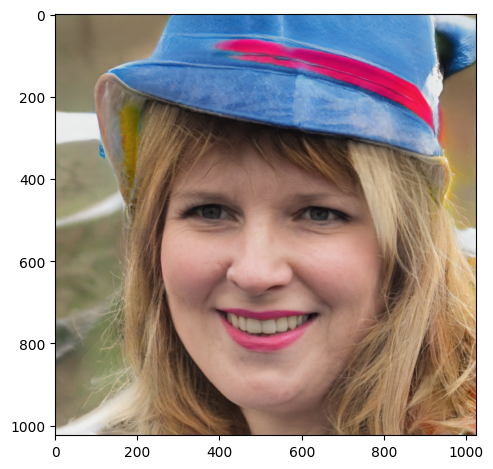

In [20]:
with torch.no_grad():
    img = Style_GAN_Generator(z, None)

img = (img - img.min()) / (img.max() - img.min())
img = img.clamp(0, 1)

#numpy array and reshape
img = img[0].permute(1, 2, 0).cpu().numpy()
img = (img * 255).astype(np.uint8)
img = Image.fromarray(img)

plt.imshow(img)
plt.tight_layout()
plt.show()

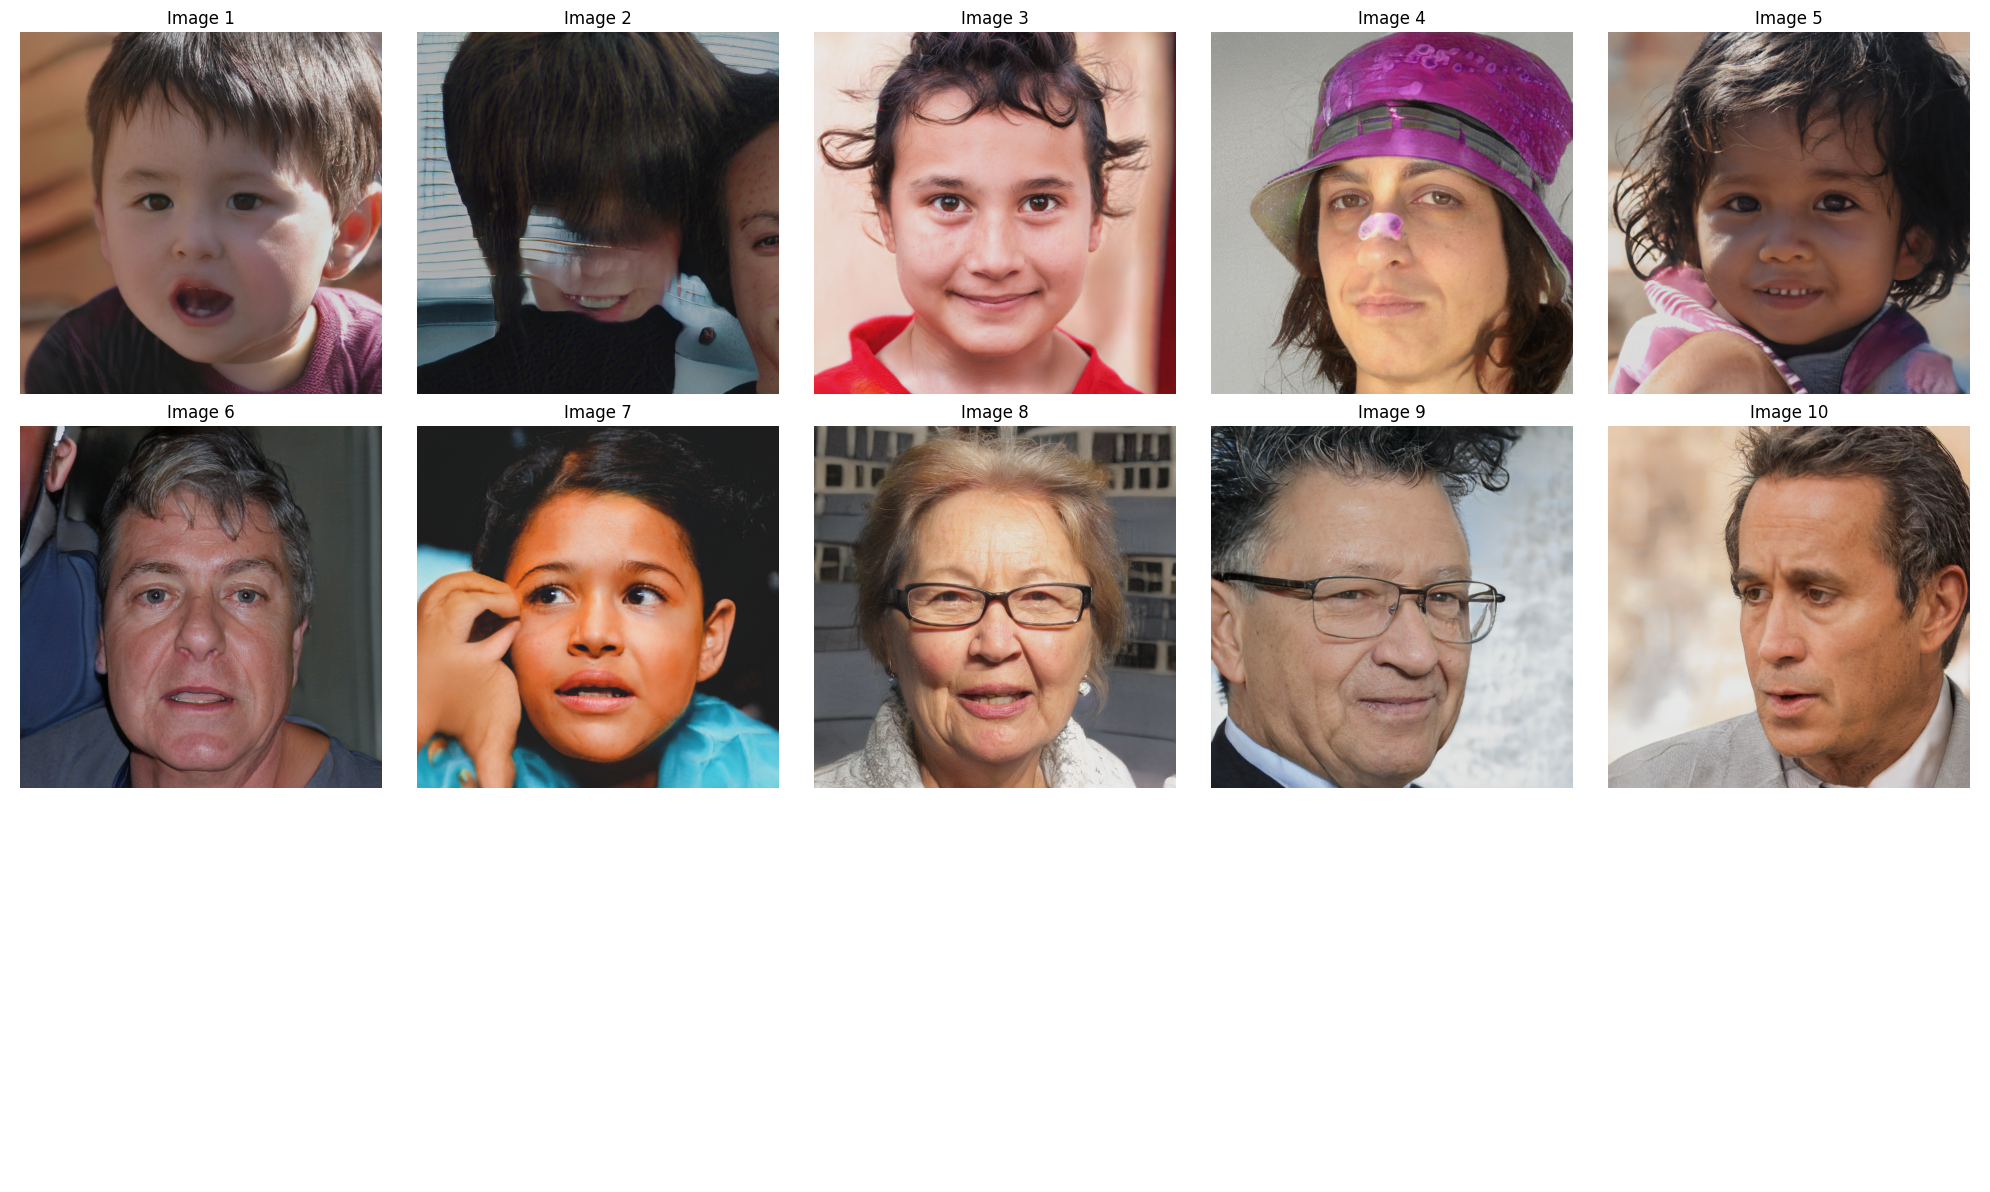

In [21]:
def generate_images(num_images):
    num_rows = (num_images // 5) + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(20, 4 * num_rows))

    for i in range(num_images):

        #generating random noise
        z = torch.randn(1, Style_GAN_Generator.z_dim, device=device)
        c = None

        with torch.no_grad():
            img = Style_GAN_Generator(z, c)

        img = (img - img.min()) / (img.max() - img.min())
        img = img.clamp(0, 1)

        img = img[0].permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img)

        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Image {i+1}')

    for i in range(num_images, num_rows * 5):
        axes[i // 5, i % 5].axis('off')

    plt.tight_layout()
    plt.show()

generate_images(10)


Part 2

In [22]:
!python3 /content/stylegan2-ada-pytorch/projector.py --help

Usage: projector.py [OPTIONS]

  Project given image to the latent space of pretrained network pickle.

  Examples:

  python projector.py --outdir=out --target=~/mytargetimg.png \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

Options:
  --network TEXT        Network pickle filename  [required]
  --target FILE         Target image file to project to  [required]
  --num-steps INTEGER   Number of optimization steps  [default: 1000]
  --seed INTEGER        Random seed  [default: 303]
  --save-video BOOLEAN  Save an mp4 video of optimization progress  [default:
                        True]
  --outdir DIR          Where to save the output images  [required]
  --help                Show this message and exit.


In [50]:
!python3 /content/stylegan2-ada-pytorch/projector.py --outdir=out/nidhi --target=/content/nidhi.jpg \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl --save-video=False

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/projector.py", line 210, in <module>
    run_projection() # pylint: disable=no-value-for-parameter
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/content/stylegan2-ada-pytorch/projector.py", line 168, in run_projection
    target_pil = PIL.Image.open(target_fname).convert('RGB')
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3227, in open
    fp 

In [51]:
!python3 /content/stylegan2-ada-pytorch/projector.py --outdir=out/aayush --target=/content/aayush.jpg \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl --save-video=False

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/projector.py", line 210, in <module>
    run_projection() # pylint: disable=no-value-for-parameter
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/content/stylegan2-ada-pytorch/projector.py", line 168, in run_projection
    target_pil = PIL.Image.open(target_fname).convert('RGB')
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3227, in open
    fp 

In [52]:
!python3 /content/stylegan2-ada-pytorch/projector.py --outdir=out/hany --target=/content/hany.jpg \
      --network=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl --save-video=False

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Traceback (most recent call last):
  File "/content/stylegan2-ada-pytorch/projector.py", line 210, in <module>
    run_projection() # pylint: disable=no-value-for-parameter
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 1434, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/usr/local/lib/python3.10/dist-packages/click/core.py", line 783, in invoke
    return __callback(*args, **kwargs)
  File "/content/stylegan2-ada-pytorch/projector.py", line 168, in run_projection
    target_pil = PIL.Image.open(target_fname).convert('RGB')
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3227, in open
    fp 

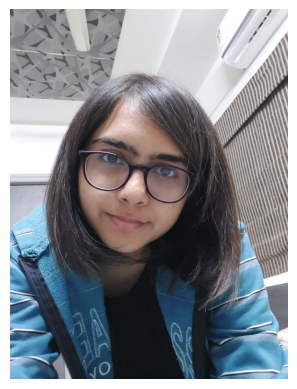

In [37]:
import matplotlib.image as mpimg

img_0 = mpimg.imread("/content/nidhi.jpeg")

plt.imshow(img_0)
plt.axis('off')
plt.show()

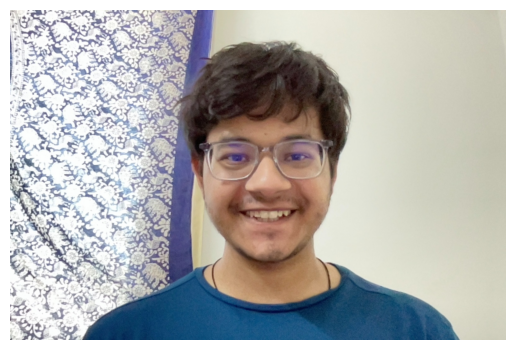

In [38]:
img_1 = mpimg.imread("/content/aayush.jpeg")

plt.imshow(img_1)
plt.axis('off')
plt.show()

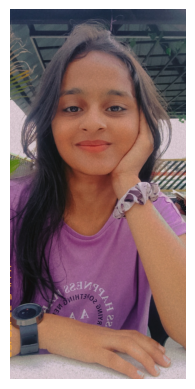

In [39]:
img_2 = mpimg.imread("/content/hany.jpeg")

plt.imshow(img_2)
plt.axis('off')
plt.show()

In [32]:
a=0.3

In [44]:
#(encode(img_0))
z = torch.randn(1, Style_GAN_Generator.z_dim, device=device)
c = None
with torch.no_grad():
    imgz_0 = Style_GAN_Generator(z, c)

In [45]:
#(encode(img_0))
z = torch.randn(1, Style_GAN_Generator.z_dim, device=device)
c = None
with torch.no_grad():
    imgz_1 = Style_GAN_Generator(z, c)

In [46]:
z_interpolated = (1 - a) * imgz_0 + a * imgz_1

In [48]:
num_steps=5
images = []

In [49]:
for alpha in range(num_steps + 1):
  alpha = alpha / num_steps
  z_interpolated = (1 - alpha) * img_0 + alpha * img_1
  interpolated_image = decode(z_interpolated)
  images.append(interpolated_image)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [54]:
import matplotlib.image as mpimg

img = mpimg.imread("/content/stylegan2-ada-pytorch/nidhi.jpeg")
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/stylegan2-ada-pytorch/nidhi.jpeg'

In [55]:
import numpy as np

ls_nidhi = np.load('/content/stylegan2-ada-pytorch/out/vidit/projected_w.npz')['w']
ls_aayush = np.load('/content/stylegan2-ada-pytorch/out/shreejan/projected_w.npz')['w']
ls_hany = np.load('/content/stylegan2-ada-pytorch/out/shaurya/projected_w.npz')['w']

FileNotFoundError: [Errno 2] No such file or directory: '/content/stylegan2-ada-pytorch/out/vidit/projected_w.npz'